# Calculate, save and plot various skill scores and their ranking

In [1]:
import xarray as xr
from datatree import DataTree
import matplotlib.pyplot as plt

import valenspy as vp
from valenspy.preprocessing_tasks.select import select_point

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## 0. Load single point simulation

In [2]:
# define points to abstract (lon, lat)
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
}

point_id = "betrix"
point_coord = d_point_coords[point_id]

In [3]:
# define function to load a single point simulation

def load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord):

    ds_obs = manager.load_data(ref_dataset, variable, period=[1995,1995], freq="hourly", region="europe")

    if variable in ['tas','clt', 'clh', 'clm', 'cll']:
        daily_statistic = "mean"
        ds_obs = ds_obs.resample(time='1D').mean()

    elif variable == 'pr': 
 
        daily_statistic = "sum"
        ds_obs = ds_obs.resample(time='1D').sum()

    elif variable == "tasmax": 
        daily_statistic = "max"
        ds_obs = ds_obs.resample(time='1D').max()
   

    # for both datasets, select summer months (JJA)
    ds_obs = ds_obs.sel(time=ds_obs.time.dt.month.isin([6,7,8]))

    # make sure both Datasets have the same daily time axis
    ds_obs['time'] = ds_obs['time'].dt.floor('D')

    # do point selection
    ds_obs_point = select_point(ds_obs, point_coord)

    da_obs = ds_obs_point[variable].compute()

    if len(experiments)>1:
        d_da_mod = {}


        for experiment in experiments: 
            ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])

            ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))

            ds_mod['time'] = ds_mod['time'].dt.floor('D')

            ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

            da_mod = ds_mod_point[variable].compute()

            d_da_mod[experiment] = da_mod
        
        # make datatree from experiments
        dt_mod = DataTree.from_dict(d_da_mod)

        return da_obs,dt_mod

    else: 
        experiment = experiments[0]
        ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])

        ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))

        ds_mod['time'] = ds_mod['time'].dt.floor('D')

        ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

        da_mod = ds_mod_point[variable].compute()

        return da_obs,da_mod



## 2. Skill score calculation example 
in this example we select one reference database, one variable and three experiments for which the skill scores are calculated

In [4]:
from valenspy.diagnostic_visualizations import plot_metric_ranking
from valenspy.diagnostic_functions import calc_metrics, get_ranks_metrics, root_mean_square_error


Load point modelled data and observations

In [ ]:
# settings
ref_dataset = 'ERA5'
variable = 'tas'
model = 'CCLM'
experiments = [ "BE28_Nick", "BE28_Nukleus_3h", "BE28_Ruben"]

# load point observations and model experiments as a data tree
da_obs, dt_mod =  load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord)

dt_mod

: 

Calculate one metric (eg root mean square error)

In [6]:
# get the data array from the data tree. 
da_mod = dt_mod[experiments[0]][variable]


rmse = root_mean_square_error(da_mod, da_obs)

rmse

1.5646958661157018

Calculate various metrics, saved in pandas dataframe

In [7]:
# calculate the metrics
df_metric      = calc_metrics(dt_mod, da_obs)
df_metric

,metric,BE28_Nick,BE28_Nukleus_3h,BE28_Ruben
0,Mean Bias,0.1146696431845549,-0.697993227803047,-0.5881581421415321
1,Mean Absolute Error,1.210128,1.331106,1.311187
2,MAE at 90th Percentile,0.303114,1.378242,1.290373
3,MAE at 99th Percentile,0.906014,1.899298,1.472369
4,MAE at 10th Percentile,0.026852,0.268115,0.057745
5,MAE at 1st Percentile,0.570807,0.067402,0.271425
6,Root Mean Square Error,1.564696,1.704533,1.658611
7,Spearman Correlation,0.92038,0.923786,0.92283
8,Perkins Skill Score,0.869565,0.891304,0.858696


Calculate the ranking of those metrics ( 1- best to 3 - worst)

In [8]:
df_ranks = get_ranks_metrics(df_metric)
df_ranks

,BE28_Nick,BE28_Nukleus_3h,BE28_Ruben
metric,,,
Mean Bias,1.0,3.0,2.0
Mean Absolute Error,1.0,3.0,2.0
MAE at 90th Percentile,1.0,3.0,2.0
MAE at 99th Percentile,1.0,3.0,2.0
MAE at 10th Percentile,1.0,3.0,2.0
MAE at 1st Percentile,3.0,1.0,2.0
Root Mean Square Error,1.0,3.0,2.0
Spearman Correlation,3.0,1.0,2.0
Perkins Skill Score,2.0,1.0,3.0


Plot the ranks in a heatmap

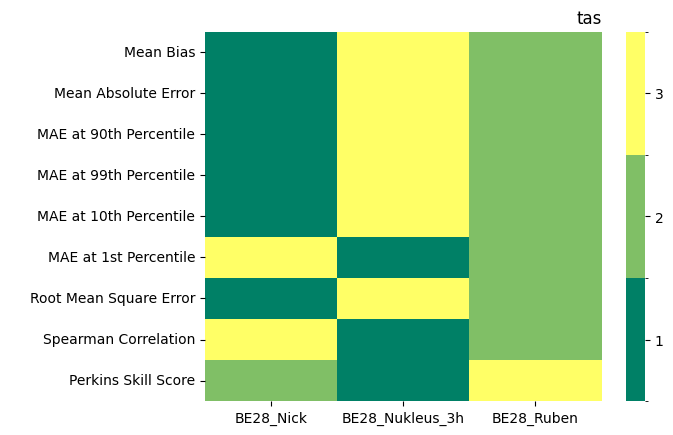

In [11]:
# calculate and plot the ranking of this metric

ax = plot_metric_ranking(df_metric, title=variable)


## 3. Skill score calculation example: multiple variables, saving of metrics as csv and plotting
Here, the metrics are saved in a csv path in the /output directory, which is not tracked by git

In [15]:
ref_dataset = 'ERA5'
variables = ['tas', 'clt']
model = 'CCLM'

experiments = [ "BE28_Nick", "BE28_Nukleus_3h", "BE28_Ruben"]

d_df_metric_rank = {}
d_df_metric = {}

for variable in variables: 
    da_obs, dt_mod =  load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord)
    
    # name of csv file
    # retrieve the dataset name from the da attribute in the datatree
    dataset = dt_mod[list(dt_mod.groups)[1]][list(dt_mod[list(dt_mod.groups)[1]].keys())[0]].dataset
    csv_path = f"../output/metrics_{point_id}_{variable}_{da_obs.dataset}_{dataset}_.csv"

    df_metric      = calc_metrics(dt_mod, da_obs, save_csv=True)
    df_metric_rank = get_ranks_metrics(df_metric)

    d_df_metric_rank[variable] =  df_metric_rank
    d_df_metric[variable]      =  df_metric

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/BE28_Nick/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/BE28_Nukleus_3h/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200

 Plotting example with customized plot script (more variables)

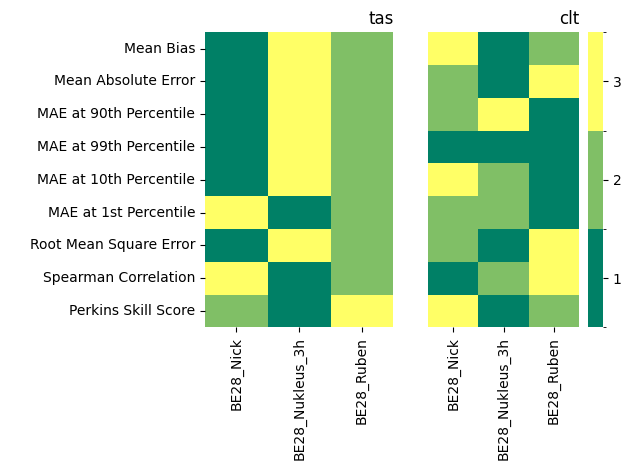

In [16]:


fig, axes = plt.subplots(1,len(variables))
axes = axes.flatten()

for i,variable in enumerate(variables): 
    ax = axes[i]
    df_metric = d_df_metric[variable] 

    if i == 0: 
        ax = plot_metric_ranking(df_metric, ax=ax, title=variable, plot_colorbar=False)
        ax.set_ylabel(' ')

    else:
        ax = plot_metric_ranking(df_metric, ax=ax, title=variable, plot_colorbar=True)

        ax.set_yticks([])
    
fig.tight_layout()

## 4. Showcase Perkins Skill score

Showcase if individual skill score calculation and how the Perkins skill score works

In [17]:
from valenspy.diagnostic_functions import get_userdefined_binwidth
from valenspy.diagnostic_visualizations import visualize_perkins_skill_score


In [18]:
# load some data

# settings
ref_dataset = 'ERA5'
variable = 'tas' 
model = 'CCLM'
experiments = ["BE28_Ruben"]

# load point observations and model experiments as a data array
da_obs, da_mod =  load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord)

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/BE28_Ruben/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


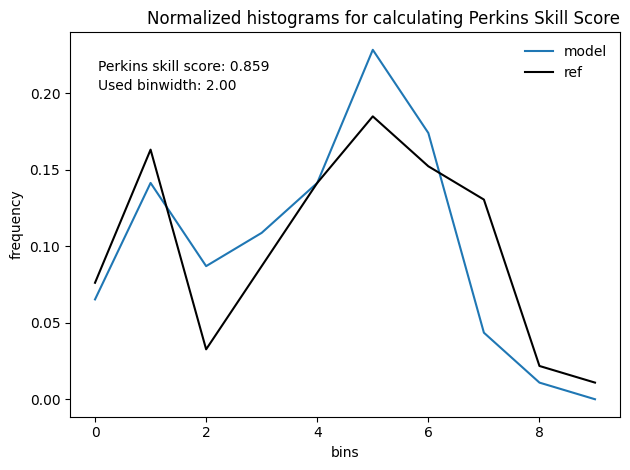

In [19]:
binwidth = get_userdefined_binwidth(variable)  # Replace `None` with actual variable if needed

visualize_perkins_skill_score(da_mod, da_obs, binwidth= binwidth)


## 5. Test functionalities of skill score calculations

for different input dimensions

In [5]:
from valenspy.diagnostic_functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score

In [6]:
# load observations and model simulations for different variables. 

ref_dataset = 'ERA5'
variables = ['tas', 'pr']
variable = variables[0]
model = 'CCLM'
experiment = "BE28_Ruben"

ds_obs = manager.load_data(ref_dataset, variables, period=[1995,1995], freq="hourly", region="europe")

if variable in ['tas','clt', 'clh', 'clm', 'cll']:
    daily_statistic = "mean"
    ds_obs = ds_obs.resample(time='1D').mean()

elif variable == 'pr': 

    daily_statistic = "sum"
    ds_obs = ds_obs.resample(time='1D').sum()

elif variable == "tasmax": 
    daily_statistic = "max"
    ds_obs = ds_obs.resample(time='1D').max()


# for both datasets, select summer months (JJA)
ds_obs = ds_obs.sel(time=ds_obs.time.dt.month.isin([6,7,8]))

# make sure both Datasets have the same daily time axis
ds_obs['time'] = ds_obs['time'].dt.floor('D')

ds_mod = manager.load_data(model, variables, freq="daily", path_identifiers=[experiment, daily_statistic])

ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))

ds_mod['time'] = ds_mod['time'].dt.floor('D')


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/total_precipitation/hourly/era5-hourly-europe-total_precipitation-1995.nc


In [22]:
ds_obs

<xarray.Dataset> Size: 69MB
Dimensions:  (time: 92, lat: 163, lon: 289)
Coordinates:
  * lon      (lon) float32 1kB -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * lat      (lat) float32 652B 33.0 33.25 33.5 33.75 ... 72.75 73.0 73.25 73.5
  * time     (time) datetime64[ns] 736B 1995-06-01 1995-06-02 ... 1995-08-31
Data variables:
    tas      (time, lat, lon) float64 35MB dask.array<chunksize=(1, 51, 99), meta=np.ndarray>
    pr       (time, lat, lon) float64 35MB dask.array<chunksize=(1, 51, 99), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    history:           2020-02-19 02:16:05 GMT by grib_to_netcdf-2.16.0: /opt...
    period:            [1995, 1995]
    freq:              hourly
    region:            europe
    dataset:           ERA5
    path_identifiers:  ['BE28_Ruben', 'mean']

In [ ]:
ds_mod[variable]

In [ ]:
mae = mean_absolute_error(ds_mod[variable], ds_obs[variable], percentile=None)

mae

NameError: name 'mean_bias' is not defined

In [ ]:
bias = mean_bias(ds_mod[variable], ds_obs[variable])

bias

: 

In [ ]:
rmse = root_mean_square_error(ds_mod[variable], ds_obs[variable])

In [ ]:
bias = mean_bias(ds_mod[variable], ds_obs[variable])

bias

NameError: name 'mean_bias' is not defined

In [ ]:
corr = spearman_correlation((ds_mod[variable], ds_obs[variable])
corr

In [ ]:
perkins_skill_score